# Identify & Track Marine Heatwaves using `spot_the_blOb`

## Processing Steps:
1. Fill holes in the binary data, using `dask_image.ndmorph` -- up to `R_fill` cells in radius.
2. Filter out small objects -- area less than the `area_filter_quartile` of the distribution of objects.
3. Identify objects in the binary data, using `dask_image.ndmeasure`.
4. Manually connect objects across time, applying Sun et al. 2023 criteria:
    - Connected Blobs must overlap by at least `overlap_threshold=50%` of the smaller blob.
    - Merged Blobs retain their original ID, but split the blob based on parent centroid locality.
5. Cluster and reduce the final object ID graph using `scipy.sparse.csgraph.connected_components`.

N.B.: Exploits parallelised `Dask` operations with optimised chunking using `flox` for memory efficiency and speed \
N.N.B.: This example using 40 years of Daily outputs at 0.25° resolution takes ~6 minutes on 128 total cores.

In [1]:
import xarray as xr
import dask
from getpass import getuser
from pathlib import Path

import spot_the_blOb as blob
import spot_the_blOb.helper as hpc

In [2]:
# Start Dask Cluster
client = hpc.StartLocalCluster(n_workers=32, n_threads=2)

Memory per Worker: 15.74 GB


Hostname is  l40195
Forward Port = l40195:8787
Dashboard Link: localhost:8787/status


In [3]:
# Load Pre-processed Data (cf. `01_preprocess_extremes.ipynb`)

file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'extreme_events_binary.zarr'
chunk_size = {'time': 25, 'lat': -1, 'lon': -1}
ds = xr.open_zarr(str(file_name), chunks=chunk_size)

In [4]:
# Extract Binary Features and Modify Mask

extreme_bin = ds.extreme_events.isel(time=slice(0, 600))
mask = ds.mask.where((ds.lat<85) & (ds.lat>-90), other=False)

In [5]:
# Tracking Parameters

drop_area_quartile = 0.5
filling_radius = 8
allow_merging = True

In [6]:
# Spot the Blobs

tracker = blob.Spotter(extreme_bin, mask, R_fill=filling_radius, area_filter_quartile=drop_area_quartile, allow_merging=allow_merging)
#blobs = tracker.run()

#blobs

In [7]:
data_bin_filled = tracker.fill_holes()

In [8]:
data_bin_filtered, area_threshold, blob_areas, N_blobs_unfiltered = tracker.filter_small_blobs(data_bin_filled)

In [9]:
data_bin = data_bin_filtered

In [10]:
blob_id_field, _ = tracker.identify_blobs(data_bin, time_connectivity=False)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Calculate Properties of each Blob
blob_props = tracker.calculate_blob_properties(blob_id_field, properties=['area', 'centroid'])


In [13]:

# Compile List of Overlapping Blob ID Pairs Across Time
overlap_blobs_list = tracker.find_overlapping_blobs(blob_id_field)  # List of overlapping blob pairs


In [14]:
split_merged_blob_id_field_unique, merged_blobs_props, split_merged_blobs_list, merged_blobs_ledger = tracker.split_and_merge_blobs(blob_id_field, blob_props, overlap_blobs_list)


/home/b/b382615/opt/spot_the_blOb/spot_the_blOb/spot_the_blOb.py:629: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  unique_ids_by_time = xr.apply_ufunc(


In [15]:
blob_id_field_unique = split_merged_blob_id_field_unique
blobs_props = merged_blobs_props
overlap_blobs_list = split_merged_blobs_list

In [16]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from dask import persist
from dask.base import is_dask_collection
from numba import jit, prange

In [17]:
IDs = np.unique(overlap_blobs_list) # 1D sorted unique

# Create a mapping from ID to indices
ID_to_index = {ID: index for index, ID in enumerate(IDs)}

# Convert overlap pairs to indices
overlap_pairs_indices = np.array([(ID_to_index[pair[0]], ID_to_index[pair[1]]) for pair in overlap_blobs_list])

# Create a sparse matrix representation of the graph
n = len(IDs)
row_indices, col_indices = overlap_pairs_indices.T
data = np.ones(len(overlap_pairs_indices))
graph = csr_matrix((data, (row_indices, col_indices)), shape=(n, n))

# Solve the graph to determine connected components
num_components, component_IDs = connected_components(csgraph=graph, directed=False, return_labels=True)

# Group IDs by their component index
ID_clusters = [[] for _ in range(num_components)]
for ID, component_ID in zip(IDs, component_IDs):
    ID_clusters[component_ID].append(ID)



In [18]:
np.sum(overlap_blobs_list[:,1] == 1)

1

In [19]:
# Find the 0 element where overlap_blobs_list[:,1] == 1
np.where(overlap_blobs_list[:,1] == 1)[0][0]

5881

In [42]:
np.set_printoptions(threshold=np.inf)
overlap_blobs_list[:,0:80]

array([[   1,   12],
       [   2,   13],
       [   3,   15],
       [   6,   17],
       [   7,   16],
       [   8,   19],
       [  10,   20],
       [  11,   21],
       [  12,   22],
       [  13,   23],
       [  14, 6721],
       [  15,   24],
       [  16,   27],
       [  17,   28],
       [  18,   26],
       [  20,   29],
       [  21,   30],
       [  21,   34],
       [  22,   31],
       [  24,   33],
       [  26,   37],
       [  27,   35],
       [  28,   36],
       [  29,   38],
       [  30,   40],
       [  31,   41],
       [  32,   42],
       [  33,   44],
       [  34,   45],
       [  35,   46],
       [  36,   47],
       [  37,   48],
       [  38,   49],
       [  40,   50],
       [  40,   52],
       [  41,   53],
       [  42,   54],
       [  43,   55],
       [  45,   56],
       [  46,   60],
       [  47,   58],
       [  48,   61],
       [  49,   63],
       [  50,   64],
       [  51,   66],
       [  52,   68],
       [  53,   69],
       [  54,

In [41]:
ID_clusters[0]

[1,
 11,
 12,
 21,
 22,
 30,
 31,
 34,
 40,
 41,
 45,
 50,
 51,
 52,
 53,
 56,
 64,
 66,
 68,
 69,
 72,
 78,
 79,
 81,
 82,
 85,
 89,
 90,
 92,
 96,
 101,
 102,
 103,
 108,
 115,
 116,
 117,
 119,
 122,
 127,
 129,
 131,
 132,
 136,
 140,
 142,
 144,
 147,
 154,
 156,
 158,
 162,
 166,
 168,
 171,
 179,
 181,
 183,
 188,
 191,
 193,
 194,
 199,
 203,
 206,
 207,
 208,
 212,
 217,
 220,
 221,
 223,
 231,
 234,
 235,
 242,
 244,
 245,
 253,
 255,
 258,
 264,
 270,
 275,
 278,
 279,
 281,
 287,
 289,
 290,
 293,
 299,
 301,
 303,
 309,
 313,
 314,
 323,
 326,
 335,
 339,
 347,
 350,
 359,
 361,
 362,
 371,
 372,
 382,
 383,
 391,
 392,
 399,
 409,
 417,
 423,
 431,
 433,
 439,
 441,
 447,
 454,
 456,
 459,
 463,
 465,
 466,
 472,
 475,
 477,
 478,
 484,
 486,
 490,
 495,
 496,
 499,
 503,
 506,
 509,
 510,
 515,
 519,
 522,
 523,
 526,
 531,
 534,
 542,
 545,
 551,
 559,
 568,
 571,
 575,
 580,
 590,
 594,
 595,
 603,
 605,
 606,
 614,
 616,
 617,
 625,
 627,
 628,
 637,
 639,
 640,
 649,

In [22]:
## ID_clusters now is a list of lists of equivalent blob IDs that have been tracked across time
#  We now need to replace all IDs in blob_id_field_unique that match the equivalent_IDs with the list index:  This is the new/final ID field.

# Create a dictionary to map IDs to the new cluster indices
min_int32 = np.iinfo(np.int32).min
max_old_ID = blob_id_field_unique.max().compute().data
ID_to_cluster_index_array = np.full(max_old_ID + 1, min_int32, dtype=np.int32)

# Fill the lookup array with cluster indices
for index, cluster in enumerate(ID_clusters):
    for ID in cluster:
        ID_to_cluster_index_array[ID] = np.int32(index+1) # Because these are the connected IDs, there are many fewer!
                                                            #  Add 1 so that ID = 0 is still invalid/no object

# N.B.: **Need to pass da into apply_ufunc, otherwise it doesn't manage the memory correctly with large shared-mem numpy arrays**
ID_to_cluster_index_da = xr.DataArray(ID_to_cluster_index_array, dims='ID', coords={'ID': np.arange(max_old_ID + 1)})

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 2.32 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


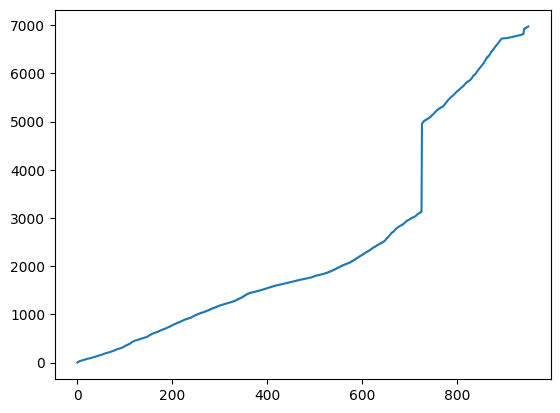

In [23]:
plt.plot(ID_clusters[0])

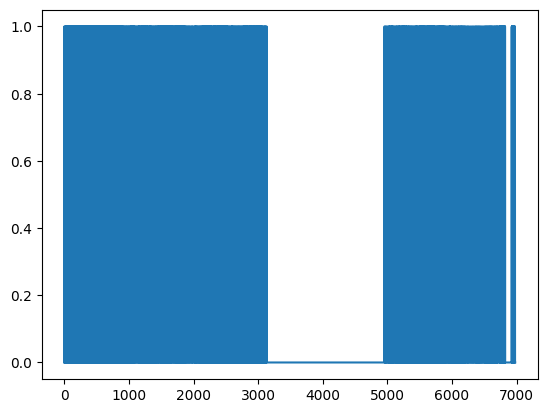

In [24]:
plt.plot(ID_to_cluster_index_array == 1)

In [25]:


def map_IDs_to_indices(block, ID_to_cluster_index_array):
    mask = block > 0
    new_block = np.zeros_like(block, dtype=np.int32)
    new_block[mask] = ID_to_cluster_index_array[block[mask]]
    return new_block

split_merged_relabeled_blob_id_field = xr.apply_ufunc(
    map_IDs_to_indices,
    blob_id_field_unique, 
    ID_to_cluster_index_da,
    input_core_dims=[[tracker.ydim, tracker.xdim],['ID']],
    output_core_dims=[[tracker.ydim, tracker.xdim]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[np.int32]
)

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 2.32 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


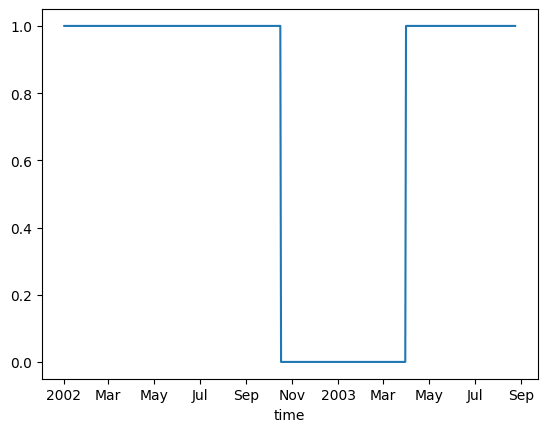

In [26]:
(split_merged_relabeled_blob_id_field == 1).any(dim={'lat','lon'}).plot()

In [27]:
### Relabel the blobs_props to match the new IDs (and add time dimension!)

max_new_ID = num_components + 1  # New IDs range from 0 to max_new_ID...
new_ids = np.arange(1, max_new_ID+1, dtype=np.int32)

# New blobs_props DataSet Structure
blobs_props_extended = xr.Dataset(coords={
    'ID': new_ids,
    tracker.timedim: blob_id_field_unique[tracker.timedim]
})

In [28]:
valid_new_ids = (split_merged_relabeled_blob_id_field > 0)      
original_ids = blob_id_field_unique.where(valid_new_ids, 0).stack(z=(tracker.ydim, tracker.xdim), create_index=False)
new_ids_field = split_merged_relabeled_blob_id_field.where(valid_new_ids, 0).stack(z=(tracker.ydim, tracker.xdim), create_index=False)

id_mapping = xr.Dataset({
    'original_id': original_ids,
    'new_id': new_ids_field
})

In [29]:
# Create list to store DataArrays for each new_id
transformed_arrays = []
for new_id in new_ids:
    
    mask = id_mapping.new_id == new_id
    mask_time = mask.any('z')
    
    original_ids = id_mapping.original_id.where(mask, 0).max(dim='z').where(mask_time, 0)
    
    transformed_arrays.append(original_ids)

# Combine all arrays along new_id dimension
global_id_mapping = xr.concat(transformed_arrays, dim='new_id')
global_id_mapping = global_id_mapping.assign_coords(new_id=new_ids)

In [30]:
new_id = 1
mask = id_mapping.new_id == new_id
mask_time = mask.any('z')

In [31]:
global_id_mapping = xr.concat(transformed_arrays, dim='new_id').assign_coords(new_id=new_ids).rename({'new_id': 'ID'}).compute()


/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 2.33 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [32]:
blobs_props_extended['global_ID'] = global_id_mapping

In [33]:
dummy = blobs_props.isel(ID=0) * np.nan
blobs_props = xr.concat([dummy.assign_coords(ID=0), blobs_props], dim='ID')

In [34]:
for var_name in blobs_props.data_vars:
    
    blobs_props_extended[var_name] = (blobs_props[var_name]
                        .sel(ID=global_id_mapping.rename({'ID':'new_id'}))
                        .drop_vars('ID').rename({'new_id':'ID'}))

In [35]:
valid_presence = blobs_props_extended['global_ID']>0  # Where we have valid data
valid_presence

<xarray.DataArray 'global_ID' (ID: 451, time: 600)> Size: 271kB
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
...
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]])
Coordinates:
  * time     (time) datetime64[ns] 5kB 2002-01-01T23:59:00 ... 2003-08-23T23:...
  * ID       (ID) int32 2kB 1 2 3 4 5 6 7 8 ... 444 445 446 447 448 449 450 451

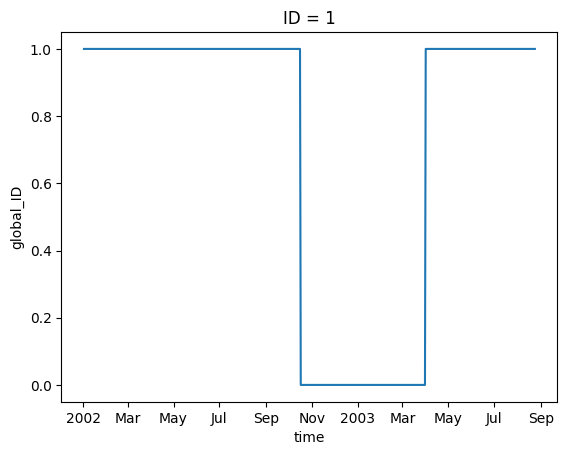

In [36]:
valid_presence.isel(ID=0).plot()

In [ ]:
# Cluster Blobs List to Determine Globally Unique IDs & Update Blob ID Field
split_merged_blobs_ds = tracker.cluster_rename_blobs_and_props(split_merged_blob_id_field_unique, merged_blobs_props, split_merged_blobs_list)

In [ ]:
# Add Merge Ledger to split_merged_blobs_ds
split_merged_blobs_ds.attrs['merge_ledger'] = merged_blobs_ledger

# Count Number of Blobs (This may have increased due to splitting)
N_blobs = split_merged_blobs_ds.ID_field.max().compute().data

In [ ]:
blobs.attrs

In [ ]:
# Save Tracked Blobs

file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'MHWs_tracked.nc'
blobs.to_netcdf(file_name, mode='w')